# Drip Line Pressure and Flow Estimator

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Functions as fun
import seaborn as sns
sns.set_context("paper",font_scale=2)

Let's get the lines from previous notebook:

In [21]:
lines = fun.import_lines()
main_line = fun.import_main_line()

In [22]:
pd.DataFrame(lines, columns=['x1','y1','x2','y2']).head()

,x1,y1,x2,y2
0,259912.219300,794407.317100,259977.921100,794417.510300
1,259913.139156,794401.388031,259978.840956,794411.581231
2,259914.059012,794395.458961,259979.760812,794405.652161
3,259914.978868,794389.529892,259980.680668,794399.723092
4,259915.898724,794383.600822,259981.600524,794393.794022


In [23]:
main_line

array([[259912.2193    , 794407.3171    ],
       [259938.89512233, 794235.37408472],
       [259906.01353769, 794163.48315452],
       [259908.77310552, 794145.69594605]])

Let's plot everything:

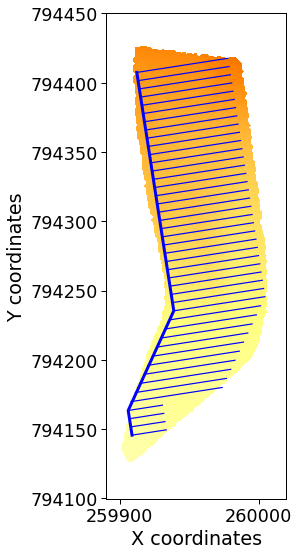

In [24]:
fun.plot_map(False, False) # Plotting map
plt.grid(b=False)

for line in lines: # Plotting drip lines
    line = line.reshape(2,2)
    plt.plot(line[:,0],line[:,1],c='blue')

plt.plot(main_line[:,0],main_line[:,1],c='blue',lw=3) # Plotting main line

The drip line we chose is with the following attributes:

TifDrip (no pressure compensating) 16/1(1.0 mm)
* L = 66 m
* Drip space = 0.4 m $\rightarrow$ 66/0.4 = 165 emitters.
* D = 0.016 m
* $q_\text{nom} = 1.5 \frac{l}{h} = 4.167 \times 10^{-7}$ m$^3$/s
* $C = 140$ (Assuming that the material is polyethylen and according to [this](https://www.engineeringtoolbox.com/hazen-williams-coefficients-d_798.html]))

With the following Flow-Pressure charchteristic:

$\displaystyle F = a\times P^{x}$

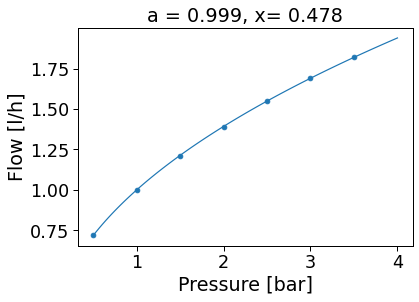

In [25]:
P = np.arange(0.5,4,0.5) # From Naan Catalog [bar]
F = np.array([0.72,1,1.21,1.39,1.55,1.69,1.82]) # From Naan Catalog [l/h]
plt.scatter(P,F)

def drip_flow_obj(parameters):
    a,x = parameters # a constant, x exponent
    return np.sum((a * P ** x - F)**2)

from scipy.optimize import minimize
a,x = minimize(drip_flow_obj, (0.5,0.5)).x

pressures = np.linspace(0.5,4,100)


plt.plot(pressures, a * pressures ** x)
plt.title('a = {:.3f}, x= {:.3f}'.format(a,x))
plt.xlabel('Pressure [bar]')
plt.ylabel('Flow [l/h]')
plt.savefig('Figures/DripFlowPressure1',bbox_inches='tight')

Let's create a function that get the pressure in head [m] and gives the flow in [m$^3$/s] according to:

* $\displaystyle P[bar] = 10^{-5} P [\text{Pa}]= \frac{9800}{10^5} Pa[\text{m}]$

* $\displaystyle F\left[\frac{\text{m}^3}{s}\right] = F\left[\frac{l}{s}\right] / (1000 \times 3600) $

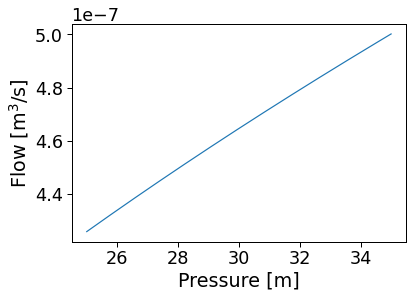

In [32]:
def drip_flow(pressure): # Getting the pressure in [m]
    a = 0.999
    x = 0.478
    pressure = pressure * (9800/1e5) # [bar]
    flow = a * pressure ** x # [l/h]
    return flow / (1000 * 3600) # [m^3/s]

P = np.linspace(25,35,1000)
plt.plot(P,drip_flow(P))
plt.xlabel('Pressure [m]')
plt.ylabel(r'Flow [m$^3$/s]')
plt.savefig('Figures/DripFlowPressure2',bbox_inches='tight')

The goal now is to calculate the pressure and flow for the first drip line. It's resemble a boundary values problem where we know the terminal state but not the initial. So the approach is to start from the end:

* Let's assume that we know the pressure of the last emitter in the drip line which is called $P_N$.
* From that we can calculate $q_N$
* We will add to it the $Q_\text{total line}$
* Calculate the section head loss according to $hf = L\left(\frac{Q_\text{total line}}{C}\right)^\alpha\frac{10.67}{D^\beta}$
* Calculating the pressure at the next emitter $P_{N-1} = P_{N} + hf + Z_N - Z_{N-1}$

And so on until we get to emitter N=1, which is the first one after the main line. Afterward we only calculate the pressure at the line $P_0$ and checking if it matches to the initial value. If not we repeat this whole procedure with better guess of $P_N$

### Application

According to the product, the maximum pressure we're allowed to work with is 3.5 bar $\rightarrow$ 35.714 m. Let's assume that the initial pressure at the begining of the first drip line is $P_0 = 35.714$ m.

Moreover, let's take a look at the first drip line profile and markering the emitters:

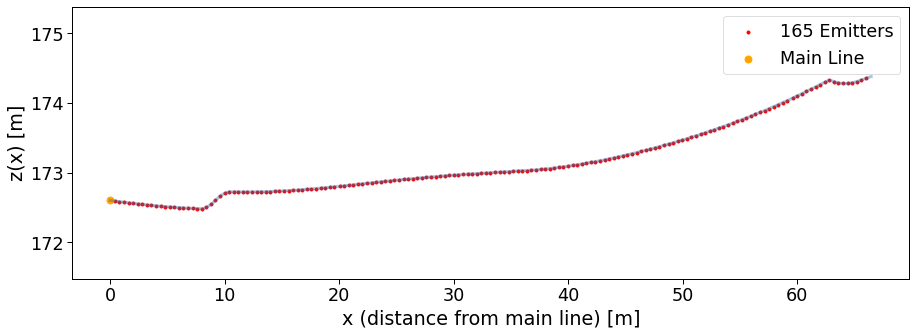

In [27]:
profile = fun.get_profile(lines[0].reshape(2,2),1000)
x = profile[:,0].flatten()
zx = profile[:,1].flatten()

# Adding the closest location of the emitter
x_emitters = np.arange(0.4,66.4,0.4)
i = []
for e in x_emitters:
     i.append(np.argmin(np.absolute(e - x.flatten())))
x_emitters = x[i]
z_emitters = zx[i]

x_main_line = x[0]
z_main_line = zx[0]

plt.figure(figsize=(15,5))
plt.plot(x, zx,lw=3,alpha=0.4)
plt.xlabel('x (distance from main line) [m]')
plt.ylabel('z(x) [m]')
plt.scatter(x_emitters,z_emitters, s=10, c='red',label='{} Emitters'.format(len(x_emitters)))
plt.scatter(x_main_line,z_main_line, s=50, c='orange',label='Main Line')

plt.ylim(min(zx)-1,max(zx) + 1)
plt.legend()

Text(0.5, 0.98, 'The main line pressure is 32.11 m, The drip line whole flow is 782.25 m$^3$/s e-7')

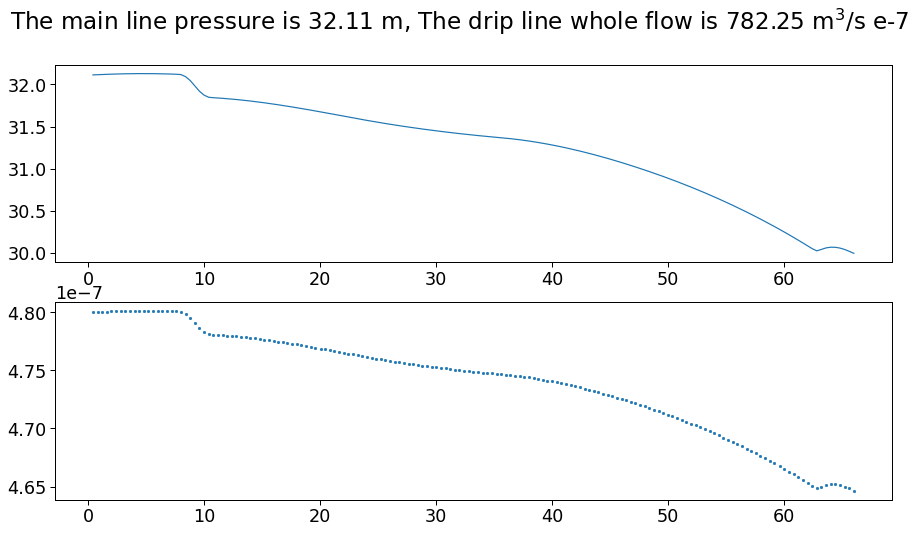

In [28]:
class DripLineEstimator():
    def __init__(self, L_space=0.4, D=0.016, C=140):
        self.L_space = L_space
        self.D = D # [m]
        self.C = C
        self.alpha = 1.852
        self.beta = 4.87        
    def estimate(self, P_terminal_guess, x_main_line, x_emitters, z_main_line, z_emitters):
        self.x_points = np.append(x_main_line,x_emitters)
        self.z_points = np.append(z_main_line,z_emitters)
        
        self.P_line = np.array([P_terminal_guess])
        self.Q_line = np.array([])
        
        for i in np.arange(-1,-len(self.x_points),-1):
            z = self.z_points[i]
            z_pre = self.z_points[i-1] # The altitude of emitter N-1
            q = drip_flow(self.P_line[-1])
            self.Q_line = np.append(self.Q_line, q)
            hf = self.L_space * ((np.sum(self.Q_line) / self.C) ** self.alpha) * (10.67 / (self.D ** self.beta))
            self.P_line = np.append(self.P_line, hf + self.P_line[-1] + z - z_pre)
            
        # Reversing the order
        self.P_line = self.P_line[::-1]
        self.Q_line = self.Q_line[::-1]
        
        # Seperating the main line pressure from the drip line
        self.P_main_line = self.P_line[0]
        self.P_line = self.P_line[1:]
        
        return self.P_line, self.Q_line, self.P_main_line


est = DripLineEstimator()
P_line,Q_line,P_main_line = est.estimate(30,
                                         x_main_line,
                                         x_emitters,
                                         z_main_line,
                                         z_emitters)


fig, axes = plt.subplots(2,1, figsize=(15,8)) 
axes[0].plot(x_emitters,P_line)
axes[1].scatter(x_emitters,Q_line,s=5)
 
title = r'The main line pressure is {:.2f} m, The drip line whole flow is {:.2f} m$^3$/s e-7'
fig.suptitle(title.format(P_main_line, (np.sum(Q_line)*1e7)))

Now let's try to get the right $P_0 = 35.714$ m.

In [29]:
from scipy.optimize import fsolve

def f(variable):
    P_terminal_guess = variable[0]
    est = DripLineEstimator()
    _,_,P_main_line = est.estimate(P_terminal_guess,
                                   x_main_line,
                                   x_emitters,
                                   z_main_line,
                                   z_emitters)
    return P_main_line - 35.714
P_terminal_value = fsolve(f,np.array([32]))[0] # Initial guess of 32
P_terminal_value

33.56647481340322

Let's try it:

Text(0.5, 0.98, 'The main line pressure is 35.71 m, The drip line whole flow is 823.78 m$^3$/s e-7')

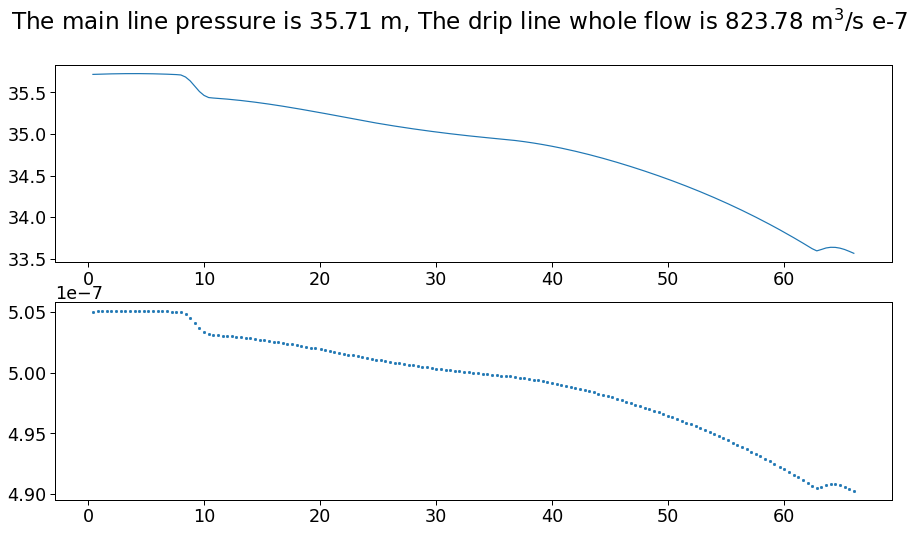

In [30]:
est = DripLineEstimator()
P_line,Q_line,P_main_line = est.estimate(P_terminal_value,
                                                     x_main_line,
                                                     x_emitters,
                                                     z_main_line,
                                                     z_emitters)


fig, axes = plt.subplots(2,1, figsize=(15,8)) 
axes[0].plot(x_emitters,P_line)
axes[1].scatter(x_emitters,Q_line,s=5)
 
title = r'The main line pressure is {:.2f} m, The drip line whole flow is {:.2f} m$^3$/s e-7'
fig.suptitle(title.format(P_main_line, (np.sum(Q_line)*1e7)))

Perfect, we will pack everything inside Function.py.

Text(0.5, 0.98, 'The main line pressure is 35.71 m, The drip line whole flow is 823.78 m$^3$/s e-7')

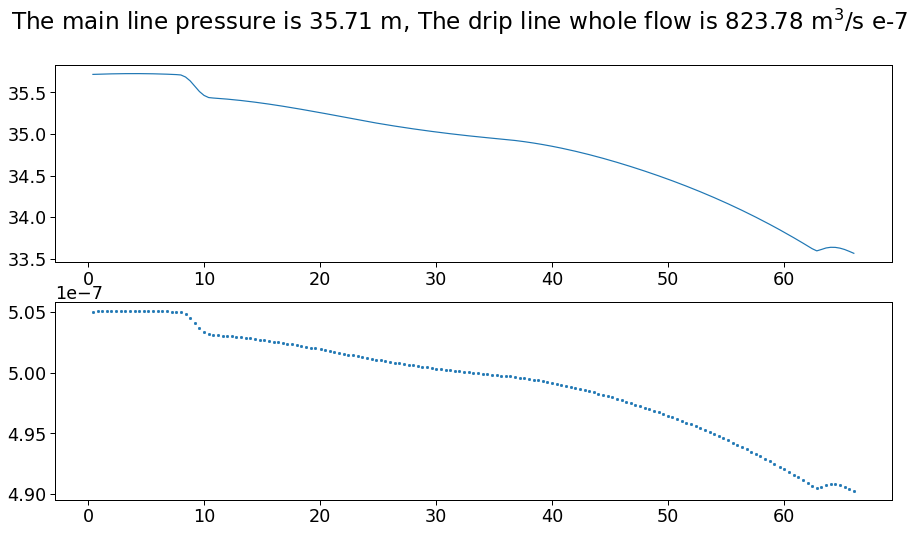

In [31]:
# Checking if the estimator in Function.py is working

est = fun.DripLineEstimator()

'''
The arguments are:
    1) The main line pressure
    2) x_main_line - the distance of main line from main line - 0 all the time
    3) x_emitters - the distance of all emitter from main line
    4) z_main_line - the altitude of main line connection point to the drip line
    5) z_emitters - the altitude of all emitters.
'''
P_line,Q_line,P_main_line = est.estimate(35.714, x_main_line, x_emitters, z_main_line, z_emitters)

fig, axes = plt.subplots(2,1, figsize=(15,8)) 
axes[0].plot(x_emitters,P_line)
axes[1].scatter(x_emitters,Q_line,s=5)
 
title = r'The main line pressure is {:.2f} m, The drip line whole flow is {:.2f} m$^3$/s e-7'
fig.suptitle(title.format(P_main_line, (np.sum(Q_line)*1e7)))